In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import ast

In [2]:
prices = pd.read_json('stock_prices.json')
sentiments = pd.read_json('aligned_sentiments.json')

indices = []

for item in prices.columns.values:
    indices.append(ast.literal_eval(item))
    
prices.columns = pd.MultiIndex.from_tuples(indices)

indices = []

for item in sentiments.columns.values:
    indices.append(ast.literal_eval(item))
    
sentiments.columns = pd.MultiIndex.from_tuples(indices)

In [3]:
buy_prices = prices['Open']
sell_prices = prices['Close']
sent_df = sentiments['bert_body']
missing_prices = list(buy_prices.isna().sum()[buy_prices.isna().sum() != 0].index)
missing_prices.remove('OGN')


buy_prices.drop(columns=missing_prices, inplace=True)
sell_prices.drop(columns=missing_prices, inplace=True)
sent_df.drop(columns=missing_prices, inplace=True)

/home/jradhima/miniconda3/envs/thesis/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
set(sent_df.columns).intersection(set(missing_prices))

set()

In [5]:
set(buy_prices.columns).intersection(set(missing_prices))

set()

In [6]:
set(sell_prices.columns).intersection(set(missing_prices))

set()

In [7]:
largest_n = sent_df.apply(lambda x: pd.Series(x.nlargest(20).index), axis=1)

In [12]:
days = len(largest_n.index)
holding_days = 3
n = 5
capital = 1000000
positions = {}
final_capital = 0
long_amounts = []

for day in range(days):
    if day % 100 == 0:
        print(day)
    if day < holding_days:
        best = largest_n.iloc[day, :n].values
        amount = capital / (holding_days * n)
        long_amounts.append(amount)
        long_positions = [(company, amount / buy_prices.iloc[day+1][company]) for company in best]
        positions[day] = {'long': long_positions}
    else:
        days_long = sum([shares * sell_prices.iloc[day][company] 
                          for company, shares in positions[day - holding_days]['long']])
        long_amounts.append(days_long/n)
        if days - day <= holding_days:
            final_capital += days_long
        else:
            best = largest_n.iloc[day, :n].values
            amount = (days_long) / (n)
            long_positions = [(company, amount / buy_prices.iloc[day+1][company]) for company in best]
            positions[day] = {'long': long_positions}#, 'short': short_positions}
final_capital / capital

0
100
200
300
400
500
600
700


1.4084660186877282

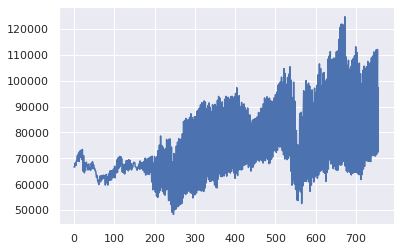

In [13]:
plt.plot(long_amounts)